In [1]:
import os
import re
import copy
import numpy as np
import pandas as pd
from scipy.signal import convolve2d
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import spectral.io.envi as envi
import rampy as rp
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
from skimage import measure
from skimage.transform import probabilistic_hough_line, hough_line_peaks, hough_line
from skimage.feature import canny
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from skimage.measure import block_reduce
from scipy.signal import savgol_filter
import tensorflow as tf

In [23]:
filename = '32MOhm_1min_middle_1mm_2mkm_50cp'
img = envi.open(filename + '.hdr')
shifts = pd.read_csv('shifts.csv', engine = 'python', sep = '\t', header = None).to_numpy().flatten()
roi = np.array([[0,1500],[1700,2500],[2850,3399]])
arr = []


for x in range(img.shape[0]):
    
    for y in range(img.shape[1]):
        
        temp = img.read_pixel(x,y)
        arr.append(temp)

In [3]:
def calc(spectra, shifts, roi):
    
    ycalc_poly, base_poly = rp.baseline(x_input = np.array(shifts), 
                                        y_input = spectra, 
                                        bir = roi, 
                                        method = 'arPLS', 
                                        lab = 10 **6)
    
    return ycalc_poly, base_poly

inputs = tqdm(arr)
parameters = (shifts, roi)

processed_list = Parallel(8)(delayed(calc)(spec,shifts, roi) for spec in inputs)

100%|████████████████████████████████████████████████████████████████████████████| 36100/36100 [18:49<00:00, 31.96it/s]


In [4]:
k = np.array(processed_list)
k = k.reshape((img.shape[0],img.shape[1],2,1738))
df_list = pd.DataFrame(columns=['Intensity', 'Shift'])
df_list['Shift'] = shifts
df_ig = pd.DataFrame(columns = ['x','y','I'])
df_i2d = pd.DataFrame(columns = ['x','y','I'])
df_sio2 = pd.DataFrame(columns = ['x','y','I'])

for x in range(img.shape[0]):
    
    for y in range(img.shape[1]):
        
        if np.mean(k[x,y,0,:]) < 100:
        
            k[x,y,0,:] /= 100
            
        df_list['Intensity'] = k[x, y, 0, :]
        
        df_ig = df_ig.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 1400) & (df_list['Shift'] < 1700)])}, ignore_index=True)
        df_i2d = df_i2d.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 2500) & (df_list['Shift'] < 3000)])}, ignore_index=True)
        df_sio2 = df_sio2.append({'x': x, 'y': y, 'I': np.max(df_list['Intensity'][(df_list['Shift'] > 400) & (df_list['Shift'] < 600)])}, ignore_index=True)

In [5]:
matrix_sio2 = np.abs(df_sio2.pivot(columns='x', index='y', values='I'))
matrix_sio2.to_csv(filename + '_sio2.csv', header = None, index = False, sep = '\t')
matrix_sio2 = matrix_sio2.to_numpy()
matrix_ig = np.abs(df_ig.pivot(columns='x', index='y', values='I'))
matrix_ig.to_csv(filename + '_ig.csv', header = None, index = False, sep = '\t')
matrix_ig = matrix_ig.to_numpy()
matrix_i2d = np.abs(df_i2d.pivot(columns='x', index='y', values='I'))
matrix_i2d.to_csv(filename + '_i2d.csv', header = None, index = False, sep = '\t')
matrix_i2d = matrix_i2d.to_numpy()

In [24]:
matrix_ig = pd.read_csv(filename + '_ig.csv', engine = 'python', sep = '\t', header = None).to_numpy()
matrix_sio2 = pd.read_csv(filename + '_sio2.csv', engine = 'python', sep = '\t', header = None).to_numpy()
matrix_i2d = pd.read_csv(filename + '_i2d.csv', engine = 'python', sep = '\t', header = None).to_numpy()

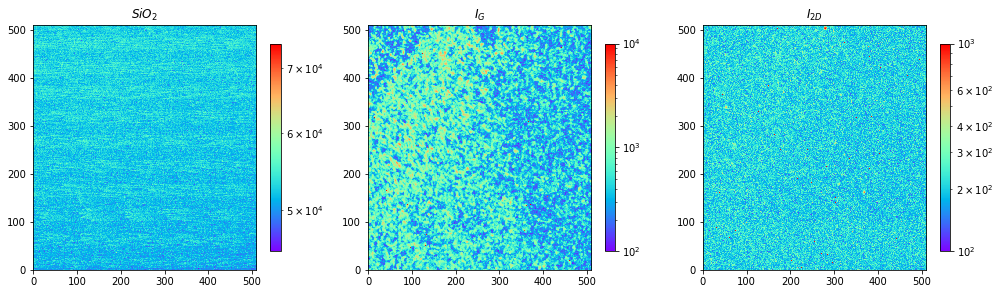

In [30]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(17, 4.5)
im0 = ax[0].imshow(matrix_sio2, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm())
cb0 = fig.colorbar(im0, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[0])
ax[0].set_title('$SiO_{2}$')
im1 = ax[1].imshow(matrix_ig, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 10**2, vmax = 10**4)
cb1 = fig.colorbar(im1, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[1])
ax[1].set_title('$I_{G}$')
im2 = ax[2].imshow(matrix_i2d, origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 10**2, vmax = 10**3)
ax[2].set_title('$I_{2D}$')
cb2 = fig.colorbar(im2, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[2])

In [7]:
def process(mtx):
    
    filt = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

    test1 = convolve2d(np.log10(mtx), filt, mode = 'same')
    test2 = convolve2d(np.log10(mtx), filt.T, mode = 'same')

    inter = (np.abs(test1) + np.abs(test2))/np.max((np.abs(test1) + np.abs(test2)))
    print(np.max(inter))
    # test1 = convolve2d(np.log10(inter), filt, mode = 'same')
    # test2 = convolve2d(np.log10(inter), filt.T, mode = 'same')
    # inter = np.abs(test1 + test2)/np.max(np.abs(test1 + test2))
    # # inter = convolve2d(inter, filt.T, mode = 'same')
    k = np.max(inter)/4
    inter[inter >= k] = k
    inter[inter < k] = 0
    inter = inter/np.max(inter)
    
    return inter

In [12]:
def find_lines(inter):
    
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 4000)
    lines = probabilistic_hough_line(inter, theta=tested_angles, threshold = 80, line_length = 20)

    # Generating figure 1
    fig, axes = plt.subplots(2, 1, figsize=(6, 10))
    ax = axes.ravel()

    ax[0].imshow(inter, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

#     ax[1].imshow(np.log(1 + h),
#                  extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
#                  cmap=cm.gray, aspect=1/1.5)
#     ax[1].set_title('Hough transform')
#     ax[1].set_xlabel('Angles (degrees)')
#     ax[1].set_ylabel('Distance (pixels)')
#     ax[1].axis('image')

    ax[1].imshow(inter, cmap=cm.gray)
    origin = np.array((0, inter.shape[1]))
    y = []
    for line in lines:
        
        try:
        
            y0, y1 = (line[1][1] - line[0][1])/(line[1][0] - line[0][0]) * origin + line[1][1] - (line[1][1] - line[0][1])/(line[1][0] - line[0][0]) * line[1][0]
            ax[1].plot(origin, (y0, y1), '-r')
            y.append((y0, y1))
            
        except:
            
            pass
        
    ax[1].set_xlim(origin)
    ax[1].set_ylim((inter.shape[0], 0))
    # ax[2].set_axis_off()
    ax[1].set_title('Detected lines')

    plt.tight_layout()
    plt.show()
    
    return y

In [13]:
# def find_lines(inter):
    
#     tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 4000)
#     h, theta, d = probabilistic_hough_line(inter, theta=tested_angles)

#     # Generating figure 1
#     fig, axes = plt.subplots(1, 3, figsize=(15, 6))
#     ax = axes.ravel()

#     ax[0].imshow(inter, cmap=cm.gray)
#     ax[0].set_title('Input image')
#     ax[0].set_axis_off()

#     ax[1].imshow(np.log(1 + h),
#                  extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
#                  cmap=cm.gray, aspect=1/1.5)
#     ax[1].set_title('Hough transform')
#     ax[1].set_xlabel('Angles (degrees)')
#     ax[1].set_ylabel('Distance (pixels)')
#     ax[1].axis('image')

#     ax[2].imshow(inter, cmap=cm.gray)
#     origin = np.array((0, asd.shape[1]))
#     y = []
#     for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#         y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
#         ax[2].plot(origin, (y0, y1), '-r')
#         y.append((y0, y1))
#     ax[2].set_xlim(origin)
#     ax[2].set_ylim((inter.shape[0], 0))
#     # ax[2].set_axis_off()
#     ax[2].set_title('Detected lines')

#     plt.tight_layout()
#     plt.show()
    
#     return y

In [14]:
def get_indices(y, size):
    
    x = np.ones((size, size))
    
    for item in y:
                
        k = (item[1] - item[0]) / size
            
        if abs(k) < 1:
        
            indices = np.ceil(np.arange(0, size, 1) * k + item[0])
                
            if item[0] < size / 2:
                    
                for i in range(size):
                    
                    x[:int(indices[i]), i] = 0
                    
            else:
                
                for i in range(size):
                    
                    x[int(indices[i]):, i] = 0
                    
        else:
            
            point = -item[0]/k
            
            indices = np.ceil(np.arange(0, size, 1) * 1/k + point)
            
            if point < size / 2:
                
                for i in range(size):
                    
                    x[i, :int(indices[i])] = 0
                    
            else:
                
                for i in range(size):
                    
                    x[i, int(indices[i]):] = 0
                    
    return x

1.0


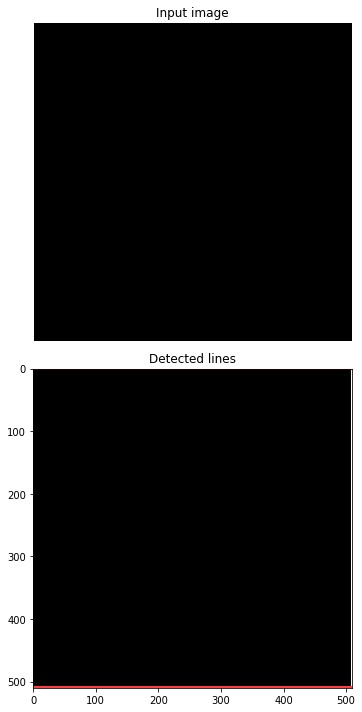

In [31]:
x = get_indices(find_lines(process(np.copy(matrix_sio2))), matrix_sio2.shape[0])

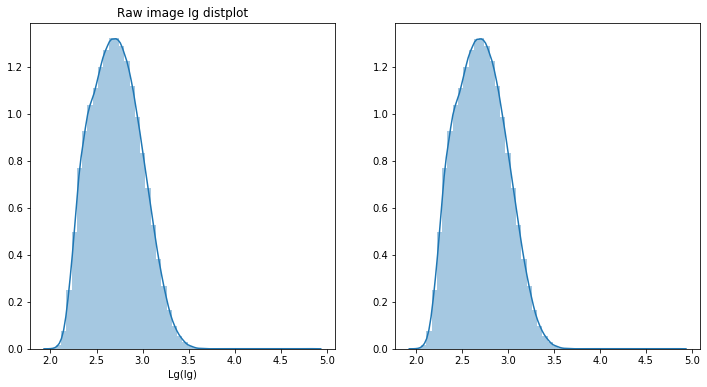

In [36]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

matrix_masked = np.copy(matrix_ig)

for i in range(matrix_masked.shape[0]):
    
    for j in range(matrix_masked.shape[1]):
        
        if x[i,j] < 1:
        
            matrix_masked[i,j] = 1e-6

sns.distplot(np.log10(matrix_ig.flatten()), ax = ax[0])

ax[0].set_title('Raw image Ig distplot')
ax[0].set_xlabel('Lg(Ig)')

sns.distplot(np.log10(matrix_masked.flatten())[(matrix_masked.flatten()) > 1e-6], ax = ax[1])

# ax[1].set_title('Channel area Ig distplot')
# ax[1].set_xlabel('Lg(Ig)')

Покрытие = 49.94732795078816 %


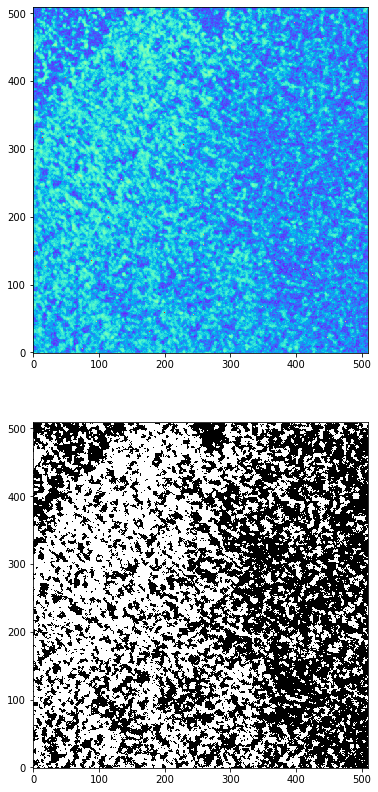

In [34]:
peak_presence = np.copy(matrix_masked)

for i in range(peak_presence.shape[0]):
    
    for j in range(peak_presence.shape[1]):
        
        if peak_presence[i,j] < 500:
            
            peak_presence[i,j] = 0
            
        else:
            
            peak_presence[i,j] = 1
            
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(6, 14)

smth = np.copy(np.log10(matrix_ig))

im1 = ax[0].imshow((smth), origin='lower', cmap=cm.rainbow, aspect='auto')

im2 = ax[1].imshow(np.ma.masked_where(x == 0, peak_presence), origin='lower', cmap=cm.gray, aspect='auto')

print('Покрытие = {} %'.format(np.count_nonzero(peak_presence)/(peak_presence.shape[0] * peak_presence.shape[1]) * 100))

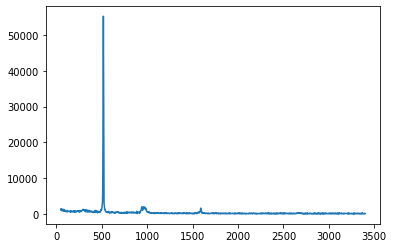

In [35]:
plt.plot(shifts[:], arr[2500][:])

In [22]:
(np.count_nonzero(peak_presence))

81269

In [ ]:
plt.imshow

In [ ]:
shit1 = np.copy(matrix_ig)

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
ax[0].imshow(np.log10(matrix_ig), origin='lower', cmap=cm.rainbow, aspect='auto', vmin = 2, vmax = 4)
ax[0].set_title('Better resolution')
ax[1].imshow(np.log10(shit), origin='lower', cmap=cm.rainbow, aspect='auto', vmin = 2, vmax = 4)
ax[1].set_title('Better resolution, last version')

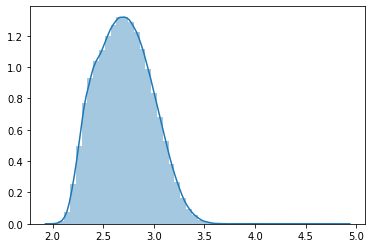

In [31]:
sns.distplot(np.log10(matrix_ig).flatten())

In [40]:
np.argmax(matrix_ig)

59535

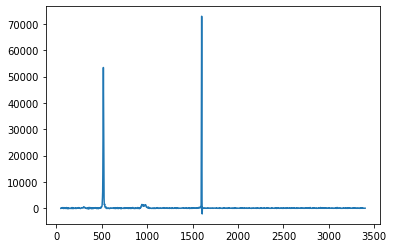

In [48]:
plt.plot(shifts[:], k[375, 116, 0, :])

In [38]:
np.argmax?

In [165]:
a = np.array([0,1,2])

In [166]:
a1 = tf.Variable(a, dtype = 'float64')

In [167]:
a2 = tf.reshape(a1, (-1, 1))

In [168]:
a2

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[0.],
       [1.],
       [2.]])>

In [175]:
mean = tf.math.reduce_mean(a2)
std = tf.math.reduce_std(a2)

In [176]:
a3 = tf.nn.batch_normalization(a2, mean = mean, variance = std**2, offset = 0, scale = 1, variance_epsilon = 0)

In [177]:
a3

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[-1.22474487],
       [ 0.        ],
       [ 1.22474487]])>

In [180]:
a4 = tf.reshape(a3, (len(a)))

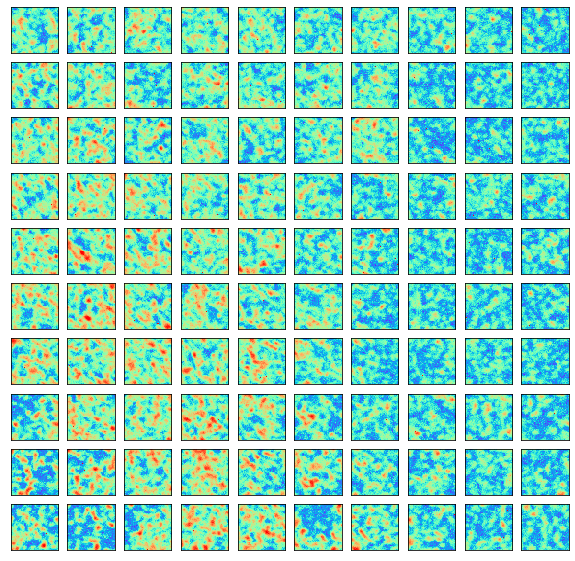

In [70]:
fig, ax = plt.subplots(10, 10)
fig.set_size_inches(10, 10)

for i in range(10):
    
    for j in range(10):
        
        ax[i, j].imshow(matrix_ig[50*i:50*(i+1), 50*j:50*(j+1)], origin='lower', cmap=cm.rainbow, aspect='auto', norm = mpl.colors.LogNorm(), vmin = 1e2, vmax = 4*1e3)
#         cb1 = fig.colorbar(im1, orientation='vertical', shrink=0.85, norm = mpl.colors.LogNorm(), ax = ax[1])
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)

In [71]:
fig.savefig('shit.png', dpi = 600)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([1.11022302e-16, 1.00000000e+00, 2.00000000e+00])>